# Astra + Kaskada Demo
## Let's use a common ML challenge: Customer Retention. 

Companies collect massive amounts of data using platforms like Splunk, Heap, Segment, or even basic event logs describing user behavior. How can you use this data to predict user retention, revenue targets, and identify which customers are likely to be the most successful?

Then how do we make that information available to the customer success reps to attempt to save accounts, to sales reps to help predict if a new customer might be successful, and to revenue leaders to predict quarterly and annual revenue targets.

**Note**: Due to the terms and conditions by which the data used in this notebook is made avaialble, anyone interested in recreating this work will need to download the data and agree to the terms and conditions of this Kaggle [research prediction competition](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data). 

#Step 1: Load data into Kaskada from Astra or Cassandra

The diagram below shows how data can be added from AstraDB or Astra Streaming to the Member and Transaction table in Kakaskada.

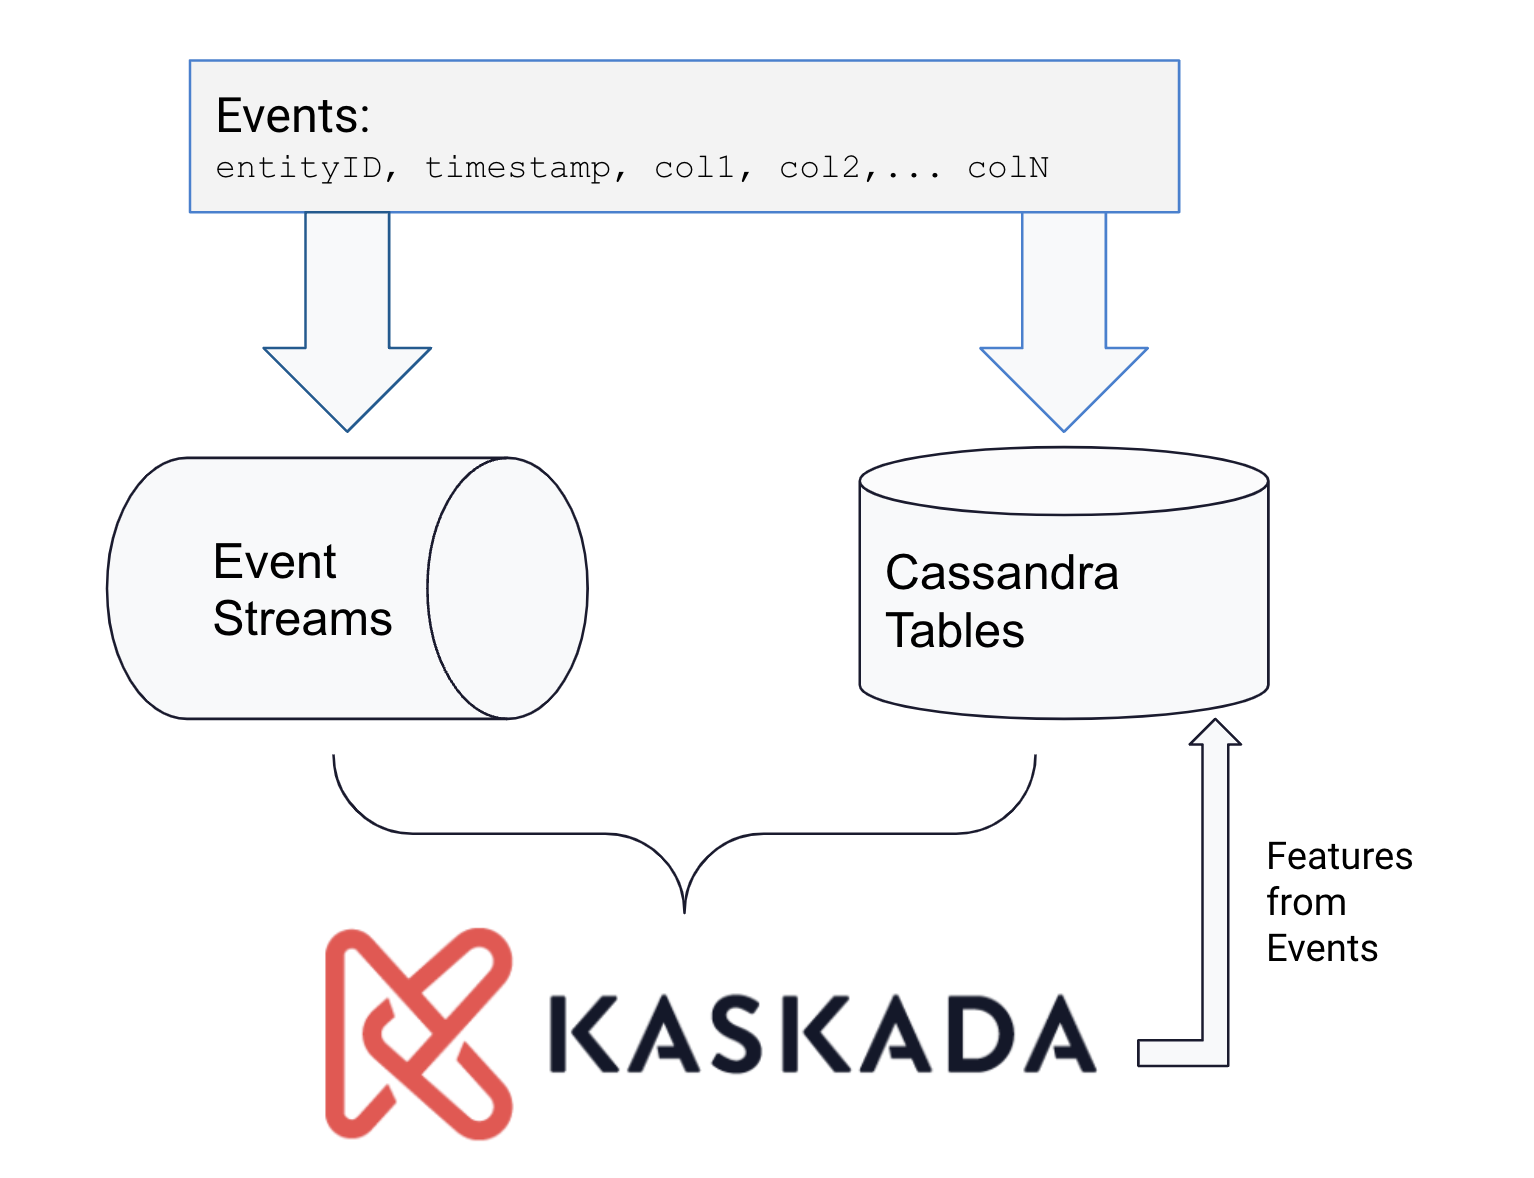

In [ ]:
from kaskada import table
table.list_tables()

tables {
  table_id: "26557d82-7032-4532-aa82-94a49f8f3b66"
  table_name: "Member"
  time_column_name: "registration_init_time"
  entity_key_column_name: "msno"
  grouping_id: "User"
  create_time {
    seconds: 1671564439
    nanos: 551894000
  }
  update_time {
    seconds: 1671564441
    nanos: 419904000
  }
  version: 10017
  schema {
    fields {
      name: "msno"
      data_type {
        primitive: PRIMITIVE_TYPE_STRING
      }
    }
    fields {
      name: "city"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "bd"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "gender"
      data_type {
        primitive: PRIMITIVE_TYPE_STRING
      }
    }
    fields {
      name: "registered_via"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "registration_init_time"
      data_type {
        primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
      }
    }
    fields {
      name: "idx"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "__index_level_0__"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
  }
  subsort_column_name {
    value: "idx"
  }
  table_source {
    kaskada {
    }
  }
}
tables {
  table_id: "05b417ad-53a0-4458-a723-af5ca0b65e7a"
  table_name: "Transaction"
  time_column_name: "transaction_date"
  entity_key_column_name: "msno"
  grouping_id: "User"
  create_time {
    seconds: 1671564437
    nanos: 59765000
  }
  update_time {
    seconds: 1671564439
    nanos: 271819000
  }
  version: 10015
  schema {
    fields {
      name: "msno"
      data_type {
        primitive: PRIMITIVE_TYPE_STRING
      }
    }
    fields {
      name: "payment_method_id"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "payment_plan_days"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "plan_list_price"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "actual_amount_paid"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "is_auto_renew"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "transaction_date"
      data_type {
        primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
      }
    }
    fields {
      name: "membership_expire_date"
      data_type {
        primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
      }
    }
    fields {
      name: "is_cancel"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "idx"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
    fields {
      name: "__index_level_0__"
      data_type {
        primitive: PRIMITIVE_TYPE_I64
      }
    }
  }
  subsort_column_name {
    value: "idx"
  }
  table_source {
    kaskada {
    }
  }
}
request_details {
  request_id: "a619dca4f63e8b337f0c80336ede38b8"
}

# Step 2: Feature Engineering
## Data scientists love Jupyter
### With Kaskada's python library and FENL magic they can keep all their favorite parts
- Iterative exploration, drill down and manipulation of data 
- Data cleaning
- Statistical modeling
- Visualization story telling with words, graphs and code
- Training ML models


### Iterative exploration, drill down and manipulation of data with Kaskada

#### Connect your event-based data directly to Kaskada

Let's take a look at the transaction events and membership information associated with a single member to understand the columns available, `msno=LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=`

In [ ]:
%%fenl
Transaction | when(Transaction.msno == "LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=")

,_key,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,idx,__index_level_0__
0,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2015-01-01,2015-02-02,0,14382,14382
1,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2015-02-01,2015-03-02,0,3626985,3626985
2,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2015-03-01,2015-04-02,0,2892776,2892776
3,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2015-03-09,2015-03-09,1,18569628,18569628
4,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2015-12-23,2016-01-22,0,19881564,19881564
...,...,...,...,...,...,...,...,...,...,...,...,...
16,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2016-12-22,2017-01-22,0,18675436,18675436
17,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2017-01-22,2017-02-22,0,6252321,6252321
18,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,149,149,1,2017-02-01,2017-02-01,1,8145718,8145718
19,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,41,30,99,99,1,2017-02-01,2017-02-28,0,13060973,13060973


In [ ]:
%%fenl
Member | when(Member.msno == "LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=")

## Data Cleaning

* Eliminate 0 or fewer plan days
* Select the maximum expiration date
* Handle backdated records
* Complete a query over all transactions to see how many we have left.
* Select and name a subset of columns we want to make available for downstream features

### Step 2a - FENL Concise Block
#### With Kaskada Data Scientists can define features directly from the event based data even when:

- The transaction log is quite busy, often with multiple entries recorded on given transaction date (transaction_date) as can be observed for this customer on several dates including 2016-09-25. 
- Some records have a value of zero or less for payment plan days (payment_plan_days) 
- Many transaction entries are changing the subscription's expiration date (membership_expire_date). 
- There are backdated records due to some kind of subscription management activity such as a change in auto-renewal status or the like. 

In [ ]:
%%fenl --var df_cleaned_transactions

#Eliminate 0 or fewer plan days
let meaningful_txns = Transaction | if(Transaction.payment_plan_days > 0)

#Identify backdated records        
let max_expires_at = max(meaningful_txns.membership_expire_date)  
let expiration_is_previous = (max_expires_at < meaningful_txns.transaction_date)

#Calculate new expiration, for backdated transactions        
let subscription_expires_at =  max_expires_at | if(not(expiration_is_previous)) | else(meaningful_txns.transaction_date)

in {
    payment_plan_days: meaningful_txns.payment_plan_days,
    payment_method_id: meaningful_txns.payment_method_id,
    trans_at: meaningful_txns.transaction_date,
    membership_expire_date: meaningful_txns.membership_expire_date,
    expires_at: subscription_expires_at
}

,_key,payment_plan_days,payment_method_id,trans_at,membership_expire_date,expires_at
0,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,30.0,41.0,2015-01-01,2015-02-02,2015-02-02
1,vQ017y/6EVjUSmMb9IJvDZUJtLkHKGnWfUAbt7nxeU0=,30.0,41.0,2015-01-01,2015-02-01,2015-02-01
2,aQu0EDyd2mjbYCZpm5ObIeZdRiH/wAiM6wzy10mc+3s=,31.0,40.0,2015-01-01,2015-01-31,2015-01-31
3,UsBmIup1CbiB3i9U2cpJUvupy2BbVqXUxYB/gBhkqBs=,31.0,40.0,2015-01-01,2015-02-01,2015-02-01
4,AdMs4wOzKfiO6hM9ayoe4CgYcHsXaoV6pDhkqEwtpzk=,31.0,40.0,2015-01-01,2015-02-01,2015-02-01
...,...,...,...,...,...,...
288556,TNOcP07Mry/UFtgvxn9bUPgq8Zf6dwdWQjn9kv7P+g0=,30.0,41.0,2017-02-28,2017-03-31,2017-03-31
288557,My/CEivMfiCWmSl9C1BNarV80eaMdd+LjsqnR8g6fsU=,30.0,34.0,2017-02-28,2017-03-31,2017-03-31
288558,OKdMxAyGn1bJ43uCyWPpr8hYYX0/gdE1Q8Jrs1mGYuI=,30.0,34.0,2017-02-28,2017-03-31,2017-03-31
288559,3XvMZe4vmCLvPQJoVdOMNt4QE4U1s5dXIW4JiebDtss=,30.0,41.0,2017-02-28,2017-03-31,2017-03-31


Create a view of this query to share the definition of cleaned transactions with all downstream features.

In [ ]:
view.create_view(
  view_name = "CleanedTransactions", 
  expression = df_cleaned_transactions.query,
)

# Step 3: Generate Labeled Dataset

Shift cleaned transactions forward in time 30 days to check if a renewal event happened. 


## Step 3.a Define labels in FENL

In [ ]:
%%fenl --var df_label_churn

# 2. Churned Transactions

let shifted_txn = CleanedTransactions 
    | shift_to($input.membership_expire_date | add_time(days(30)))

let last_txn = last(CleanedTransactions)

let membership_history = {
    trans_at: shifted_txn.trans_at,
    expires_at: shifted_txn.membership_expire_date,
    churned: shifted_txn.trans_at == last_txn.trans_at,
} | when(is_valid(shifted_txn))

let initial_txn = membership_history.trans_at | first()
let churn_txn = membership_history | if(membership_history.churned) | first()

let churn_subscription = {
    starts_at: initial_txn,
    ends_at: churn_txn.trans_at,
    churned: true
} 
let active_subscription = {
    starts_at: initial_txn,
    ends_at: null,
    churned: false
}
let current_subscription = churn_subscription | if(is_valid(churn_txn)) | else(active_subscription)
let first_transaction = CleanedTransactions | first()

in{
    churned: current_subscription.churned, 
    payment_plan_days: first_transaction.payment_plan_days,
    payment_method_id: first_transaction.payment_method_id,
    starts_at: current_subscription.starts_at,
    ends_at: current_subscription.ends_at,
} | when(is_valid(current_subscription))

,_key,churned,payment_plan_days,payment_method_id,starts_at,ends_at
0,5z4w+3H7Qu8eJxhO20SAOBc+6nPLW/Q5eY4CMKUJVGU=,True,30.0,24.0,2015-01-23,2015-01-23
1,KSyMAEmMLIMGSghRfzF44TKzYC/K1zh7wi0gEFc/GAw=,True,31.0,27.0,2015-01-23,2015-01-23
2,Ge5nM+AdnWxFm+nIORW+bfU2VyMqeGUhXs6RwXsu/+w=,False,NaN,NaN,2015-01-26,NaT
3,YhjdS3H6Oa444WB7I//4DkEX5kQUq8Yk8lr3djuhS8Y=,False,NaN,NaN,2015-01-26,NaT
4,Ge5nM+AdnWxFm+nIORW+bfU2VyMqeGUhXs6RwXsu/+w=,False,30.0,24.0,2015-01-26,NaT
...,...,...,...,...,...,...
492697,TNOcP07Mry/UFtgvxn9bUPgq8Zf6dwdWQjn9kv7P+g0=,True,30.0,41.0,2016-12-31,2017-02-28
492698,My/CEivMfiCWmSl9C1BNarV80eaMdd+LjsqnR8g6fsU=,True,NaN,NaN,2015-11-30,2017-02-28
492699,OKdMxAyGn1bJ43uCyWPpr8hYYX0/gdE1Q8Jrs1mGYuI=,True,NaN,NaN,2015-11-30,2017-02-28
492700,3XvMZe4vmCLvPQJoVdOMNt4QE4U1s5dXIW4JiebDtss=,True,30.0,41.0,2015-01-30,2015-08-31


Save labeled view to generate train test sets at different times

In [ ]:
view.create_view(
  view_name = "LabeledTransactions", 
  expression = df_label_churn.query,
)

view {
  view_id: "5ddb16e1-1bc2-4092-8ceb-41e91d7a3386"
  view_name: "LabeledTransactions"
  expression: "# 2. Churned Transactions\n\nlet shifted_txn = CleanedTransactions \n    | shift_to($input.membership_expire_date | add_time(days(30)))\n\nlet last_txn = last(CleanedTransactions)\n\nlet membership_history = {\n    trans_at: shifted_txn.trans_at,\n    expires_at: shifted_txn.membership_expire_date,\n    churned: shifted_txn.trans_at == last_txn.trans_at,\n} | when(is_valid(shifted_txn))\n\nlet initial_txn = membership_history.trans_at | first()\nlet churn_txn = membership_history | if(membership_history.churned) | first()\n\nlet churn_subscription = {\n    starts_at: initial_txn,\n    ends_at: churn_txn.trans_at,\n    churned: true\n} \nlet active_subscription = {\n    starts_at: initial_txn,\n    ends_at: null,\n    churned: false\n}\nlet current_subscription = churn_subscription | if(is_valid(churn_txn)) | else(active_subscription)\nlet first_transaction = CleanedTransactions | first()\n\nin{\n    churned: current_subscription.churned, \n    payment_plan_days: first_transaction.payment_plan_days,\n    payment_method_id: first_transaction.payment_method_id,\n    starts_at: current_subscription.starts_at,\n    ends_at: current_subscription.ends_at,\n} | when(is_valid(current_subscription))"
  result_type {
    struct {
      fields {
        name: "churned"
        data_type {
          primitive: PRIMITIVE_TYPE_BOOL
        }
      }
      fields {
        name: "payment_plan_days"
        data_type {
          primitive: PRIMITIVE_TYPE_I64
        }
      }
      fields {
        name: "payment_method_id"
        data_type {
          primitive: PRIMITIVE_TYPE_I64
        }
      }
      fields {
        name: "starts_at"
        data_type {
          primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
        }
      }
      fields {
        name: "ends_at"
        data_type {
          primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
        }
      }
    }
  }
  analysis {
    fenl_diagnostics {
    }
    free_names: "CleanedTransactions"
    free_names: "Transaction"
  }
}
request_details {
  request_id: "b203a5d24801d6a81707a48bec3e46d4"
}
analysis {
  fenl_diagnostics {
  }
  free_names: "CleanedTransactions"
  free_names: "Transaction"
}

### Generate train/test sets for any date ranges
Example of how to use views with a when to generate various train/test dataset(s) at different times as needed

In [ ]:
%%fenl
#Training set 
LabeledTransactions | when( (LabeledTransactions.starts_at > ("2017-02-01T00:00:00Z" as timestamp_ns))
    and (LabeledTransactions.starts_at <= ("2017-02-28T00:00:00Z" as timestamp_ns)))

,_key,churned,payment_plan_days,payment_method_id,starts_at,ends_at
0,kPtjurZOqN6ulJJz5j/f8ViI6oVcELan6Bsgmj6a53c=,True,30,41,2017-02-02,2017-02-02
1,USh5g9s7QotP1EWZMHdm/jYZwC52NSrQrbAtNFWXzdg=,True,30,41,2017-02-03,2017-02-03
2,xaPJHHoEgFQh8bTtiEO5lguwsZeWV0kpAhaBW7F1++c=,True,30,41,2017-02-04,2017-02-04
3,0V43KsVYP758SYQSRA8SbnqoZdwFiPIYOgVhLDB3BYw=,True,30,41,2017-02-04,2017-02-04
4,iNXZRu3iohLYBOQjTKHCGI0imcaWb38CooYRibeBBf0=,True,30,41,2017-02-04,2017-02-04
...,...,...,...,...,...,...
1098,kOD8VdKdkFoBilDI5F8MAEFpH+K9cEU3S7NImJqc9/g=,True,30,41,2017-02-28,2017-02-28
1099,DDrGFzUkw5rp0Sj29TD3rpCNnCBSY+CJwC6tmEca9d0=,True,30,23,2017-02-05,2017-02-28
1100,uEhSZBjCCt2RjDXtBC3K3/5ilDxlVawfzKMaSkn/Jf4=,True,30,41,2017-02-28,2017-02-28
1101,LcDrm/2RarwCnb3bKAtlhKufegKcoSrjAzXIpVRIono=,True,30,38,2017-02-13,2017-02-13


## Enrich with additional labels

### Step 3.c Extend any view with additional FENL Features as needed

*   Duration of subscription
*   Channels and plan selection



In [ ]:
%%fenl --var df_training
LabeledTransactions | extend({
    duration_days: days_between(LabeledTransactions.ends_at, LabeledTransactions.starts_at) as i32,
    registered_via: first(Member).registered_via | else(-1)
}) | when(is_valid(LabeledTransactions.churned))

,_key,duration_days,registered_via,churned,payment_plan_days,payment_method_id,starts_at,ends_at
0,5z4w+3H7Qu8eJxhO20SAOBc+6nPLW/Q5eY4CMKUJVGU=,0.0,9,True,30.0,24.0,2015-01-23,2015-01-23
1,KSyMAEmMLIMGSghRfzF44TKzYC/K1zh7wi0gEFc/GAw=,0.0,3,True,31.0,27.0,2015-01-23,2015-01-23
2,Ge5nM+AdnWxFm+nIORW+bfU2VyMqeGUhXs6RwXsu/+w=,NaN,9,False,NaN,NaN,2015-01-26,NaT
3,YhjdS3H6Oa444WB7I//4DkEX5kQUq8Yk8lr3djuhS8Y=,NaN,3,False,NaN,NaN,2015-01-26,NaT
4,Ge5nM+AdnWxFm+nIORW+bfU2VyMqeGUhXs6RwXsu/+w=,NaN,9,False,30.0,24.0,2015-01-26,NaT
...,...,...,...,...,...,...,...,...
492697,TNOcP07Mry/UFtgvxn9bUPgq8Zf6dwdWQjn9kv7P+g0=,-59.0,7,True,30.0,41.0,2016-12-31,2017-02-28
492698,My/CEivMfiCWmSl9C1BNarV80eaMdd+LjsqnR8g6fsU=,-456.0,9,True,NaN,NaN,2015-11-30,2017-02-28
492699,OKdMxAyGn1bJ43uCyWPpr8hYYX0/gdE1Q8Jrs1mGYuI=,-456.0,9,True,NaN,NaN,2015-11-30,2017-02-28
492700,3XvMZe4vmCLvPQJoVdOMNt4QE4U1s5dXIW4JiebDtss=,-213.0,7,True,30.0,41.0,2015-01-30,2015-08-31


# Step 4: Going to Production
## But, Data and Machine Learning Engineers Hate Jupyter
The non-linearity that was so beneficial as a data scientist turns into a nightmarish choose-your-own adventure book for the machine learning engineer trying to recreate the final path that a Data Scientist took. Whereas all the failures, mistakes, and errors that were made are useful for a data scientist to hold onto, it makes the machine learning engineers job closer to archaeology: trying to discover and interpret the hidden meaning behind for loops, boolean statements and drop cols.

### With Kaskada you can bridge the gap to production
- Kaskada connects directly the event-based data available in production
- Data scientists define the predictor features used to power training sets
- Data and ML Engineers call Kaskada to compute the **same** features at the time of now() in production
- Kaskada provides production grade targets such as Redis for feature and model serving

### Make Features as Code available for airflow jobs with views
Fenl expressions can be shared and re-used by creating a view. A view is a named expression. In subsequent Fenl expressions, the view's name is synonymous with the view's expression. Views are persisted in the Kaskada platform and are accessible to any query.

[Read more here](https://docs.kaskada.com/docs/views)

In [ ]:
%%fenl --var feature_vector

{
    payment_plan_days: Transaction.payment_plan_days,
    payment_method_id: Transaction.payment_method_id,
    trans_at: Transaction.transaction_date,
    membership_expire_date: Transaction.membership_expire_date,
}

,_key,payment_plan_days,payment_method_id,trans_at,membership_expire_date
0,LWekcgcnUIqi22v63xuIMX4GYbxapmPMoDnLMVLFSTs=,30,41,2015-01-01,2015-02-02
1,vQ017y/6EVjUSmMb9IJvDZUJtLkHKGnWfUAbt7nxeU0=,30,41,2015-01-01,2015-02-01
2,aQu0EDyd2mjbYCZpm5ObIeZdRiH/wAiM6wzy10mc+3s=,31,40,2015-01-01,2015-01-31
3,UsBmIup1CbiB3i9U2cpJUvupy2BbVqXUxYB/gBhkqBs=,31,40,2015-01-01,2015-02-01
4,AdMs4wOzKfiO6hM9ayoe4CgYcHsXaoV6pDhkqEwtpzk=,31,40,2015-01-01,2015-02-01
...,...,...,...,...,...
288556,TNOcP07Mry/UFtgvxn9bUPgq8Zf6dwdWQjn9kv7P+g0=,30,41,2017-02-28,2017-03-31
288557,My/CEivMfiCWmSl9C1BNarV80eaMdd+LjsqnR8g6fsU=,30,34,2017-02-28,2017-03-31
288558,OKdMxAyGn1bJ43uCyWPpr8hYYX0/gdE1Q8Jrs1mGYuI=,30,34,2017-02-28,2017-03-31
288559,3XvMZe4vmCLvPQJoVdOMNt4QE4U1s5dXIW4JiebDtss=,30,41,2017-02-28,2017-03-31


In [ ]:
from kaskada import view

view.create_view(
  view_name = "Features", 
  expression = feature_vector.query,
)

In [ ]:
view.list_views(search = "Features")

views {
  view_id: "07b93f9b-730c-4858-8d7c-7b78060b0361"
  view_name: "Features"
  expression: "{\n    payment_plan_days: Transaction.payment_plan_days,\n    payment_method_id: Transaction.payment_method_id,\n    trans_at: Transaction.transaction_date,\n    membership_expire_date: Transaction.membership_expire_date,\n}"
  result_type {
    struct {
      fields {
        name: "payment_plan_days"
        data_type {
          primitive: PRIMITIVE_TYPE_I64
        }
      }
      fields {
        name: "payment_method_id"
        data_type {
          primitive: PRIMITIVE_TYPE_I64
        }
      }
      fields {
        name: "trans_at"
        data_type {
          primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
        }
      }
      fields {
        name: "membership_expire_date"
        data_type {
          primitive: PRIMITIVE_TYPE_TIMESTAMP_NANOSECOND
        }
      }
    }
  }
  analysis {
    fenl_diagnostics {
    }
    free_names: "Transaction"
  }
}
request_details {
  request_id: "e5c73e04723dd40ae673b1cc5fb4ec0d"
}

The results of a Fenl query can be written to an external data store and kept up to date as the data underlying the query changes using materializations. A materialization is similar to a query, except that the results are updated any time data is added to a table used by the query. Materializations can be used to populate feature vectors in a variety of feature stores, including Casandra and Astra to be used in production for low-latency inference.

[Read more here](https://docs.kaskada.com/docs/working-with-materializations)